# **Sistem Rekomendasi Produk Amazon**

## **Import Library**

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## **Load Data**

In [2]:
!pip install -q Kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d saurav9786/amazon-product-reviews

 99% 108M/109M [00:04<00:00, 28.3MB/s]
100% 109M/109M [00:04<00:00, 24.1MB/s]


In [6]:
! unzip /content/amazon-product-reviews.zip

Archive:  /content/amazon-product-reviews.zip
  inflating: ratings_Electronics (1).csv  


## **Data Preparation**

### **Menampilkan data**

In [7]:
# Menampilkan data yang terdapat dalam dataset
df=pd.read_csv("/content/ratings_Electronics (1).csv")
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


### **Memberi Nama Kolom**

In [8]:
electronics_data=pd.read_csv("/content/ratings_Electronics (1).csv", dtype={'rating': 'int8'},
                             names=['userId', 'productId','rating','timestamp'], index_col=None, header=0)
electronics_data.head()

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5,1341100800
1,A2NWSAGRHCP8N5,0439886341,1,1367193600
2,A2WNBOD3WNDNKT,0439886341,3,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1,1334707200
4,A1QGNMC6O1VW39,0511189877,5,1397433600


### **Melihat Info Data**

In [9]:
electronics_data.shape

(7824481, 4)

In [10]:
electronics_data.describe()

,rating,timestamp
count,7.824481e+06,7.824481e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [11]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     object
 1   productId  object
 2   rating     int8  
 3   timestamp  int64 
dtypes: int64(1), int8(1), object(2)
memory usage: 186.6+ MB


In [12]:
print("Jumlah Ratings: {:,}".format(electronics_data.shape[0]) )
print("Jenis Kolom Yang Tersedia: {}".format( np.array2string(electronics_data.columns.values)) )
print("Jumlah User: {:,}".format(len(electronics_data.userId.unique()) ) )
print("Jumlah Produk: {:,}".format(len(electronics_data.productId.unique())  ) )

Jumlah Ratings: 7,824,481
Jenis Kolom Yang Tersedia: ['userId' 'productId' 'rating' 'timestamp']
Jumlah User: 4,201,696
Jumlah Produk: 476,001


### **Mengecek Baris Kosong**

In [13]:
print('Jumlah baris kosong:')
pd.DataFrame(electronics_data.isnull().sum().reset_index()).rename( columns={0:"Total Kosong","index":"Kolom"}) 

Jumlah baris kosong:


,Kolom,Total Kosong
0,userId,0
1,productId,0
2,rating,0
3,timestamp,0


## **Exploratory Data Analysis**

### **Melihat data berdasarkan waktu dan ratingnya**

In [15]:
data_by_date = electronics_data.copy()
data_by_date.timestamp = pd.to_datetime(electronics_data.timestamp, unit="s")
data_by_date = data_by_date.sort_values(by="timestamp", ascending=False).reset_index(drop=True)
print("Jumlah Ratings setiap harinya:")
data_by_date.groupby("timestamp")["rating"].count().tail(10).reset_index()

Jumlah Ratings setiap harinya:


,timestamp,rating
0,2014-07-14,9701
1,2014-07-15,6892
2,2014-07-16,5943
3,2014-07-17,4781
4,2014-07-18,4912
5,2014-07-19,4183
6,2014-07-20,4273
7,2014-07-21,5458
8,2014-07-22,5010
9,2014-07-23,695


### **Melihat grafik trends berdasarkan waktu dan total pemberian rating**

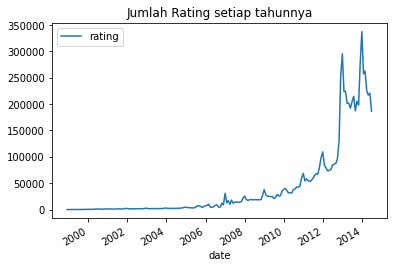

In [18]:
data_by_date["year"]  = data_by_date.timestamp.dt.year
data_by_date["month"] = data_by_date.timestamp.dt.month
rating_by_year = data_by_date.groupby(["year","month"])["rating"].count().reset_index()
rating_by_year["date"] = pd.to_datetime(rating_by_year["year"].astype("str")  +"-"+rating_by_year["month"].astype("str") +"-1")
rating_by_year.plot(x="date", y="rating")
plt.title("Jumlah Rating setiap tahunnya")
plt.show()

### **Melihat banyaknya persebaran rating yang diberikan oleh pengguna**

In [19]:
ratings = electronics_data.groupby("rating").agg({"rating":"count"})

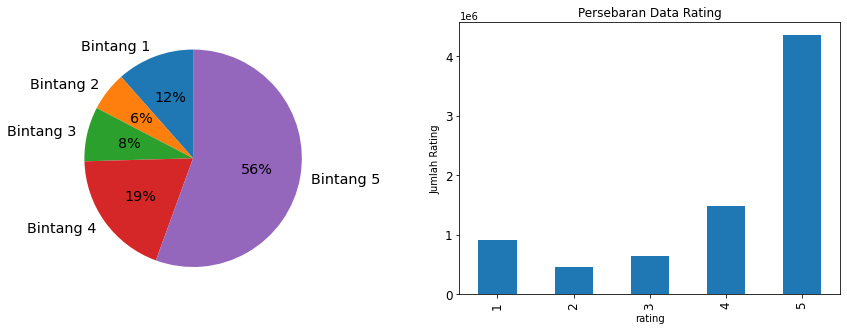

In [21]:
figsize = (15,5)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=figsize)
ratings.plot.pie(ax=ax1,y="rating", legend=False, autopct='%1.f%%', startangle=90, fontsize="x-large", 
                 labels=["Bintang 1","Bintang 2","Bintang 3","Bintang 4","Bintang 5"])
ax1.set_ylabel('')
ratings.plot.bar(ax=ax2,  fontsize="large")
ax2.set(ylabel="Jumlah Rating")
ax2.set(title="Persebaran Data Rating")
ax2.get_legend().remove()

plt.show()

### **Melihat produk teratas berdasarkan jumlah rating**

In [24]:
rating_by_product = electronics_data.groupby("productId").agg({"userId":"count","rating":"mean"}).rename(
                        columns={"userId":"Jumlah Rating", "rating":"Rata-rata Rating"}).reset_index()

In [25]:
printmd("Produk teratas berdasarkan jumlah rating")
rating_by_product.sort_values(by="Jumlah Rating",ascending=False ).reset_index(drop=True).head()

Produk teratas berdasarkan jumlah rating

,productId,Jumlah Rating,Rata-rata Rating
0,B0074BW614,18244,4.491504
1,B00DR0PDNE,16454,3.931020
2,B007WTAJTO,14172,4.424005
3,B0019EHU8G,12285,4.754497
4,B006GWO5WK,12226,4.314657


## **Modelling and Result**

### **Import Library**

In [27]:
!pip install -q tensorflow-recommenders

     |████████████████████████████████| 89 kB 3.1 MB/s 


In [28]:
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs

In [29]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        self.user_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_userIds, mask_token=None),
                                    tf.keras.layers.Embedding(len(unique_userIds)+1, embedding_dimension)
                                    ])

        self.product_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_productIds, mask_token=None),
                                    tf.keras.layers.Embedding(len(unique_productIds)+1, embedding_dimension)
                                    ])
        self.ratings = tf.keras.Sequential([
                            tf.keras.layers.Dense(256, activation="relu"),
                            tf.keras.layers.Dense(64,  activation="relu"),
                            tf.keras.layers.Dense(1)
                              ])
    def call(self, userId, productId):
        user_embeddings  = self.user_embeddings (userId)
        product_embeddings = self.product_embeddings(productId)
        return self.ratings(tf.concat([user_embeddings,product_embeddings], axis=1))

# Build a model.
class amazonModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer   = tfrs.tasks.Ranking(
                                                    loss    =  tf.keras.losses.MeanSquaredError(),
                                                    metrics = [tf.keras.metrics.RootMeanSquaredError()])
            

    def compute_loss(self, features, training=False):
        rating_predictions = self.ranking_model(features["userId"], features["productId"]  )

        return self.task( labels=features["rating"], predictions=rating_predictions)

In [30]:
cutoff_no_rat = 50    
cutoff_year   = 2011  
recent_data   = data_by_date.loc[data_by_date["year"] > cutoff_year]
print("Jumlah Rating: {:,}".format(recent_data.shape[0]) )
print("Jumlah Pengguna: {:,}".format(len(recent_data.userId.unique()) ) )
print("Jumlah Produk: {:,}".format(len(recent_data.productId.unique())  ) )
del data_by_date  
recent_prod   = recent_data.loc[recent_data.groupby("productId")["rating"].transform('count').ge(cutoff_no_rat)].reset_index(
                    drop=True).drop(["timestamp","year","month"],axis=1)
del recent_data

Jumlah Rating: 5,566,858
Jumlah Pengguna: 3,142,438
Jumlah Produk: 382,245


In [31]:
userIds    = recent_prod.userId.unique()
productIds = recent_prod.productId.unique()
total_ratings= len(recent_prod.index)

In [32]:
ratings = tf.data.Dataset.from_tensor_slices( {"userId":tf.cast( recent_prod.userId.values  ,tf.string),
                                "productId":tf.cast( recent_prod.productId.values,tf.string),
                                "rating":tf.cast( recent_prod.rating.values  ,tf.int8,) } )

In [33]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take( int(total_ratings*0.8) )
test = shuffled.skip(int(total_ratings*0.8)).take(int(total_ratings*0.2))

unique_productIds = productIds
unique_userIds    = userIds

### **Model Aktif Mempelajari Pola**

In [34]:
model = amazonModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad( learning_rate=0.1 ), metrics=['accuracy'])
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()
model.fit(cached_train, epochs=20)

Epoch 1/20
369/369 [==============================] - 62s 153ms/step - root_mean_squared_error: 1.3593 - loss: 1.8465 - regularization_loss: 0.0000e+00 - total_loss: 1.8465
Epoch 2/20
369/369 [==============================] - 22s 61ms/step - root_mean_squared_error: 1.2694 - loss: 1.6107 - regularization_loss: 0.0000e+00 - total_loss: 1.6107
Epoch 3/20
369/369 [==============================] - 26s 70ms/step - root_mean_squared_error: 1.2503 - loss: 1.5627 - regularization_loss: 0.0000e+00 - total_loss: 1.5627
Epoch 4/20
369/369 [==============================] - 22s 60ms/step - root_mean_squared_error: 1.2447 - loss: 1.5487 - regularization_loss: 0.0000e+00 - total_loss: 1.5487
Epoch 5/20
369/369 [==============================] - 22s 61ms/step - root_mean_squared_error: 1.2428 - loss: 1.5441 - regularization_loss: 0.0000e+00 - total_loss: 1.5441
Epoch 6/20
369/369 [==============================] - 23s 63ms/step - root_mean_squared_error: 1.2420 - loss: 1.5421 - regularization_loss:

### **Result**

In [35]:
user_rand = userIds[123]
test_rating = {}
for m in test.take(5):
    test_rating[m["productId"].numpy()]=RankingModel()(tf.convert_to_tensor([user_rand]),
                                                       tf.convert_to_tensor([m["productId"]]))

In [36]:
print("5 produk teratas yang direkomendasikan untuk pengguna {}: ".format(user_rand))
for m in sorted(test_rating, key=test_rating.get, reverse=True):
    print(m.decode())

5 produk teratas yang direkomendasikan untuk pengguna A32PYU1S3Y7QFY: 
B002FFG6JC
B004ABO7QI
B006YW3DI4
B0012YJQWQ
B006ZBWV0K


## **Evaluasi**

In [37]:
model.evaluate(cached_test, return_dict=True)

185/185 [==============================] - 19s 38ms/step - root_mean_squared_error: 1.3098 - loss: 1.7162 - regularization_loss: 0.0000e+00 - total_loss: 1.7162


{'root_mean_squared_error': 1.3098347187042236,
 'loss': 1.776953935623169,
 'regularization_loss': 0,
 'total_loss': 1.776953935623169}